In [2]:
from xtr_via_plaid import search, XTRRunConfig
from evaluation.evaluate_lotte_rankings import evaluate_dataset

In [1]:
def make_config(collection, datasplit, nbits, k):
    return XTRRunConfig(nranks=4, dataset="lotte", collection=collection,
                    type_="search", datasplit=datasplit, nbits=nbits, k=k)

COLLECTIONS = ["lifestyle", "pooled", "recreation", "science", "technology", "writing"]
DATASPLITS = ["dev", "test"]
NBITS = [1, 2, 4]
K = [100]
THREADS = [1, 4, 8, 16, 24]

### Evaluate Accuracy (XTR/PLAID)

In [5]:
import itertools
from tqdm import tqdm
import json
import os

if not os.path.exists("results.json"):
    results = []
    for collection, split, nbits, k in tqdm(itertools.product(COLLECTIONS, DATASPLITS, NBITS, K)):
        config = make_config(collection=collection, datasplit=split, nbits=nbits, k=k)
        rankings_path = search(config)
    
        # NOTE For now always (just) evaluate S@5
        result = evaluate_dataset(rankings_path, collection, split, k=5)
        result['config'] = {'collection': collection, 'split': split, 'nbits': nbits, 'k': k}
        results.append(result)
    
    with open("results.json", "w") as file:
        file.write(json.dumps(results))
else:
    with open("results.json", "r") as file:
        results = json.loads(file.read())

In [59]:
import pandas as pd

xtr_base = {"lifestyle": 82.1, "pooled": 69.0, "recreation":69.4, "science": 54.9, "technology": 63.2, "writing": 77.0}
xtr_xxl = {"lifestyle": 89.1, "pooled": 77.3, "recreation": 79.3, "science": 60.8, "technology": 73.7, "writing": 83.3}
colbert = {"lifestyle": 80.2, "pooled": 67.3, "recreation": 68.5, "science": 53.6, "technology": 61.9, "writing": 74.7}
colbertv2 = {"lifestyle": 84.7, "pooled": 71.6, "recreation": 72.3, "science": 56.7, "technology": 66.1, "writing": 80.1}

results_by_dataset = dict()
offset = dict()
for result in results:
    collection = result["provenance"]["dataset"]
    nbits = result["config"]["nbits"]
    
    s5 = result["metrics"]["Success@5"]
    results_by_dataset[(collection, nbits)] = round(s5 * 100.0, 1)
    offset_to_base = round(100.0 * s5 - xtr_base[collection], 1)
    if offset_to_base > 0:
        offset_to_base = f"<span style='color:green'>+ {offset_to_base}</span>"
    else:
        offset_to_base = f"<span style='color:red'>{offset_to_base}</span>"
    offset[(collection, nbits)] = offset_to_base

df = pd.DataFrame(data=[[collection, xtr_base[collection], xtr_xxl[collection], *[f"{results_by_dataset[(collection, nbits)]} ({offset[(collection, nbits)]})" for nbits in NBITS], colbert[collection], colbertv2[collection]] for collection in COLLECTIONS],
                  columns=["dataset", "XTR-base", "XTR-xxl", *[f"S@5 (nbits={nbits})" for nbits in NBITS], "ColBERT", "ColBERTv2"])

from IPython.display import display, HTML
display(HTML(df.to_html(escape=False)))

,dataset,XTR-base,XTR-xxl,S@5 (nbits=1),S@5 (nbits=2),S@5 (nbits=4),ColBERT,ColBERTv2
0,lifestyle,82.1,89.1,81.1 (+ -1.0),83.2 (+ 1.1),82.9 (+ 0.8),80.2,84.7
1,pooled,69.0,77.3,65.4 (+ -3.6),68.3 (+ -0.7),69.2 (+ 0.2),67.3,71.6
2,recreation,69.4,79.3,66.5 (+ -2.9),68.6 (+ -0.8),68.6 (+ -0.8),68.5,72.3
3,science,54.9,60.8,52.5 (+ -2.4),54.8 (+ -0.1),56.2 (+ 1.3),53.6,56.7
4,technology,63.2,73.7,60.2 (+ -3.0),62.4 (+ -0.8),63.8 (+ 0.6),61.9,66.1
5,writing,77.0,83.3,76.7 (+ -0.3),77.5 (+ 0.5),77.4 (+ 0.4),74.7,80.1


### Evaluate Latency (XTR/PLAID)

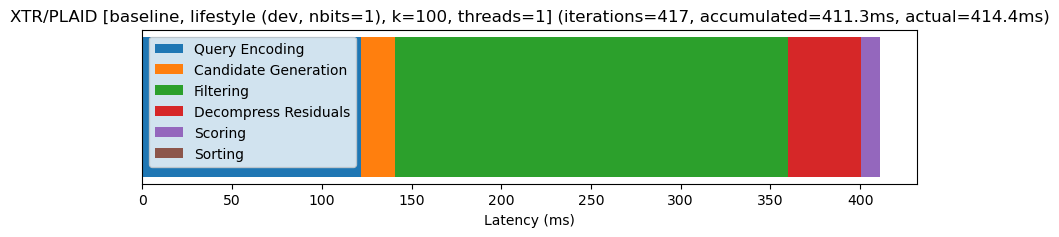

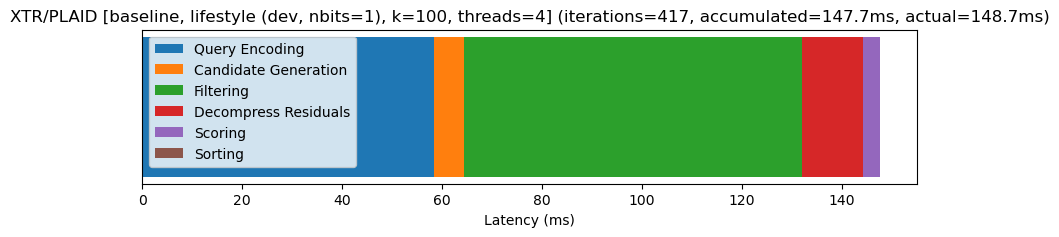

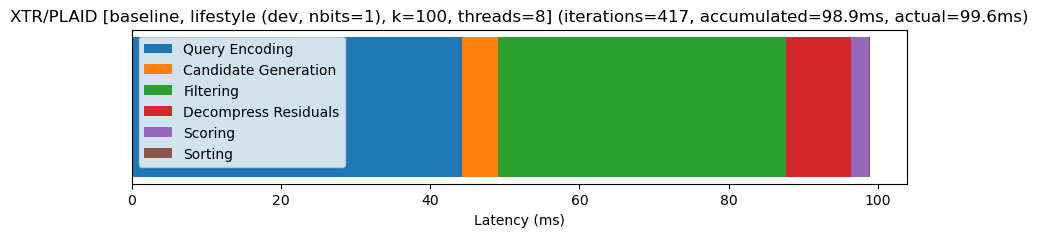

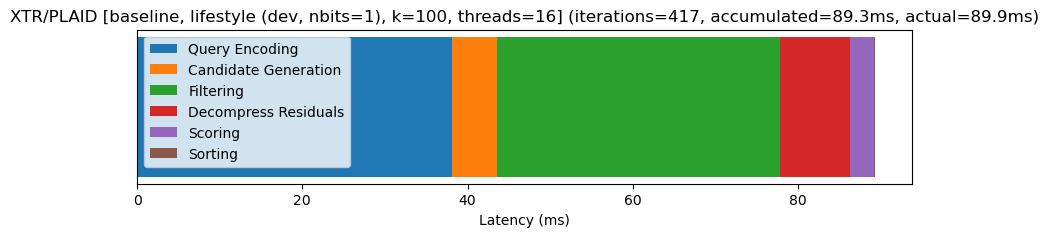

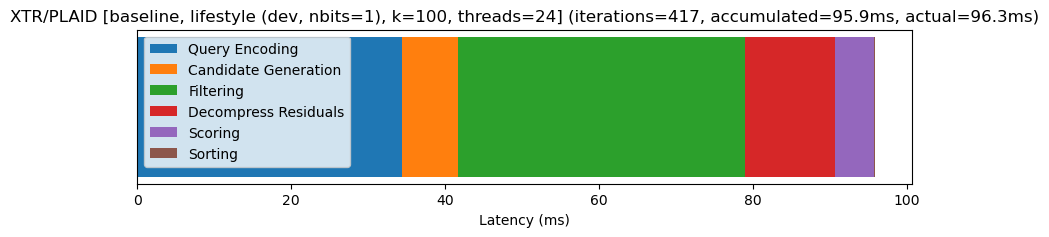

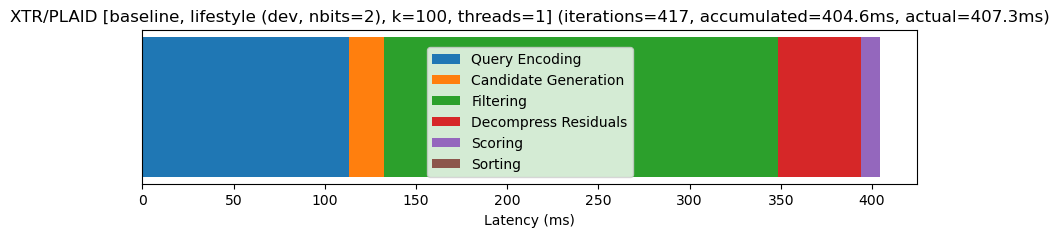

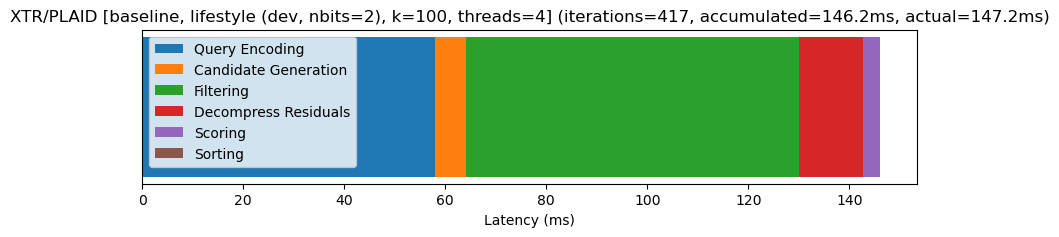

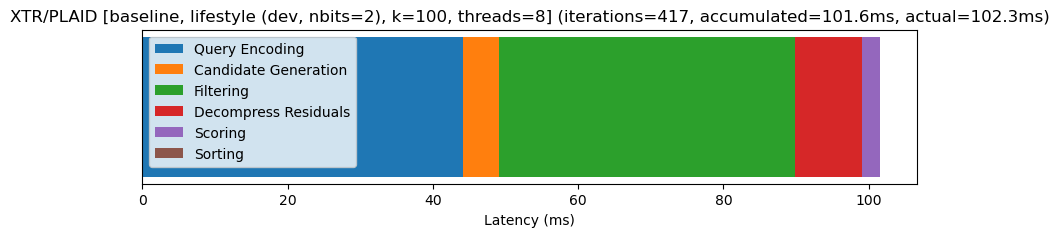

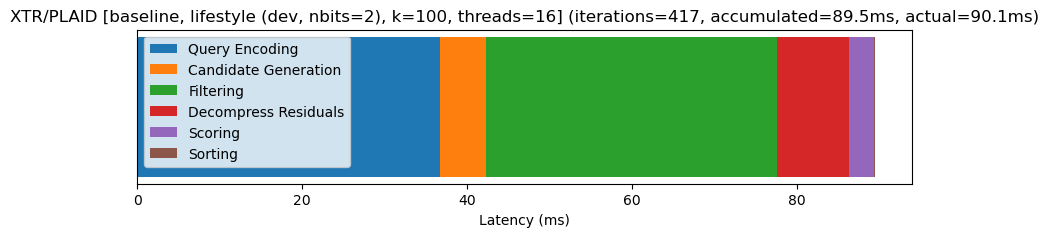

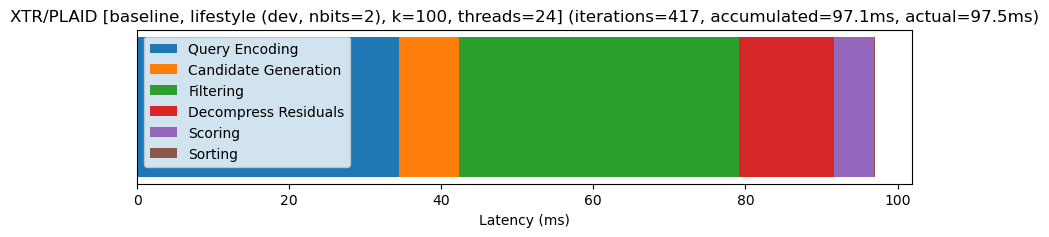

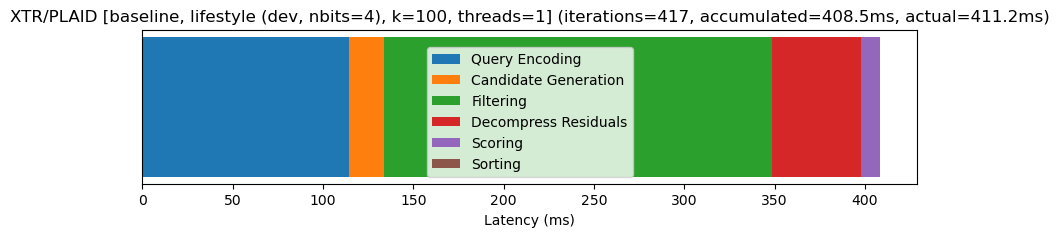

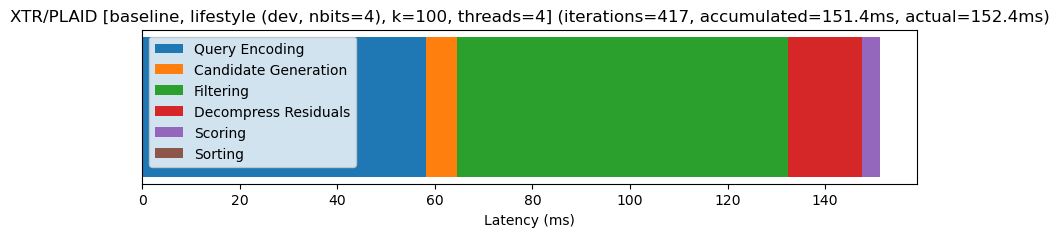

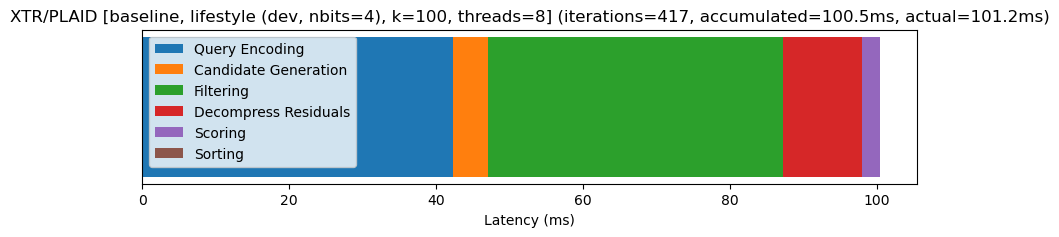

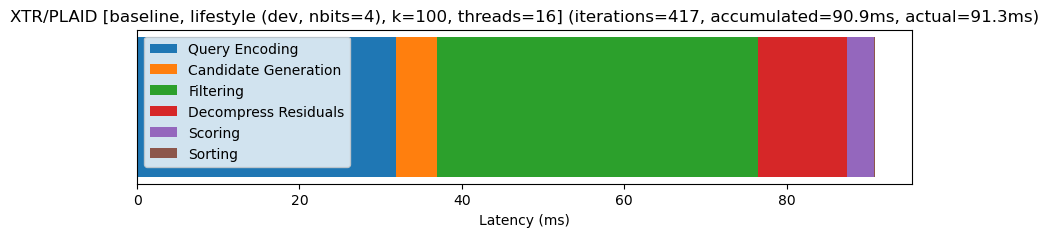

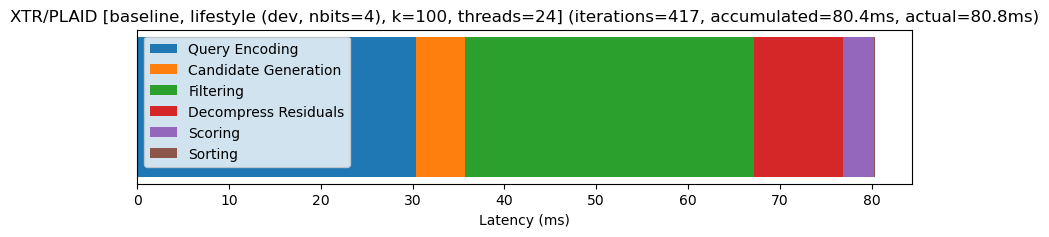

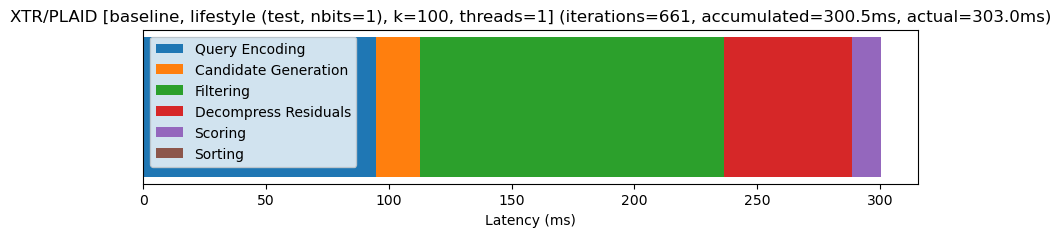

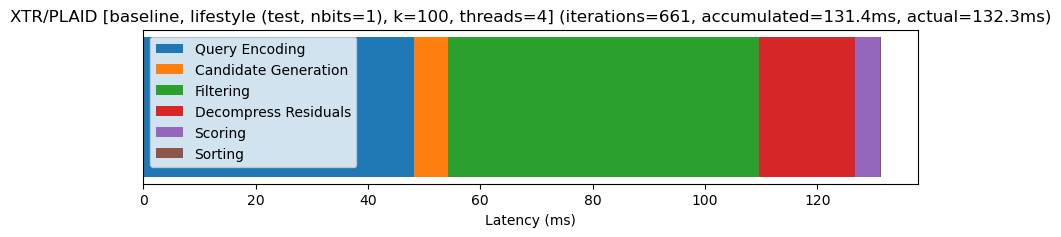

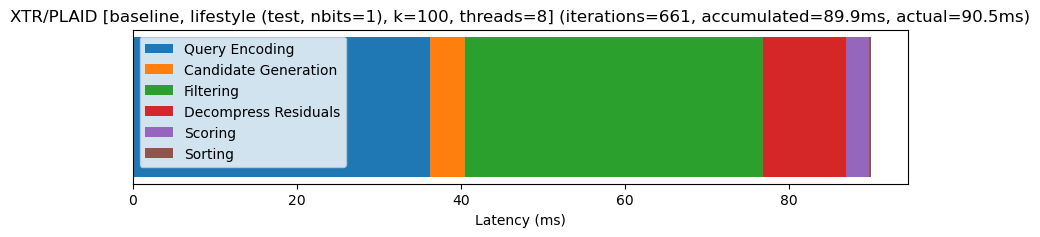

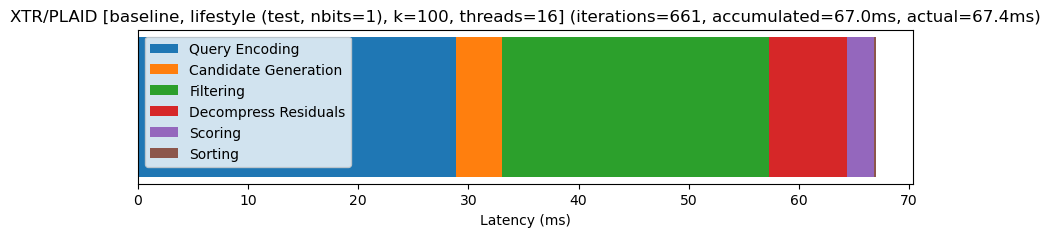

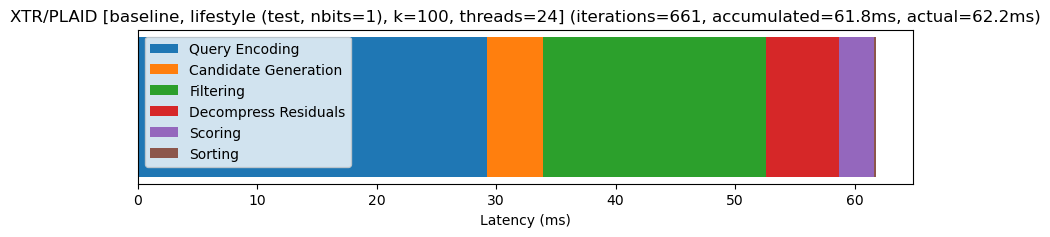

In [19]:
import os
import itertools
import json
from colbert.utils.tracker import ExecutionTracker

root_dir = "latency/xtr"
for collection, split, nbits, k, threads in itertools.product(COLLECTIONS, DATASPLITS, NBITS, K, THREADS):
    filename = f"{collection}_split={split}_nbits={nbits}_k={k}_threads={threads}.json"
    if not os.path.exists(os.path.join(root_dir, filename)):
        continue

    with open(os.path.join(root_dir, filename), "r") as file:
        data = json.loads(file.read())
    tracker = ExecutionTracker.from_dict(data["tracker"])
    tracker.display()